In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
%matplotlib notebook
plt.style.use('presentation.mplstyle')
colors_cycle=plt.rcParams.get('axes.prop_cycle')
colors = [item['color'] for item in colors_cycle]
def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == int:
            numbers += (d[item],)
            dtypes += [(item,int)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

In [2]:
alpha = np.exp(2.0/3*np.pi*1j)
A_0a =  np.array([[1, 1, 1],
                  [1, alpha**2, alpha],
                  [1, alpha, alpha**2]])

A_a0 = 1/3* np.array([[1, 1, 1],
                      [1, alpha, alpha**2],
                      [1, alpha**2, alpha]])

## Steady state solution

In [65]:

s = 0.035365
n = 1478
n_1 = 1500
s = (n_1 - n)/n_1


#V_abc = np.array([235.0,240*np.exp(1j*np.deg2rad(-117.9)),245*np.exp(1j*np.deg2rad(120))]).reshape(3,1)

s = 0.035365
omega_s = 2.0*np.pi*freq/N_pp
omega = omega_s*(1-s) 
s_pos = (omega_s - omega)/omega_s
s_neg = 2 - s_pos

s_pos = 0.035365*1.45
s_neg = 2 - s_pos
# kersting
R_s = 0.0774
X_s = 0.1843
X_mag = 4.8384
R_r = 0.0908
X_r = 0.1843

# Kersting paper
# Phase  Frame Analysis of the Effects of Voltage Unbalance on Induction Machines
Z_b = 240**2/(18642.5)
R_r = 39.4e-3*Z_b
X_r = 80e-3*Z_b
X_mag = 2.1*Z_b
R_s = 33.6e-3*Z_b
X_s = 80e-3*Z_b

# M. Al-Badri paper: 
# A Novel Full-Load Efficiency Estimation Technique for Induction Motors Operating with Unbalanced Voltages 
freq = 50.0
N_pp = 1
P_n = 5592.75  # 7.5 HP
R_s = 3.0050
X_s = 2.3155
R_fe = 4521.5*1e6
X_mag = 200.20
R_r = 2.3000
X_r = 3.4559

# ABB 90 kW
P_n = 90.0e3
freq = 50.0
N_pp = 2.0
R_r = 24e-3
X_r =196e-3
X_mag = 3.7
R_fe = 111.0
R_s = 23e-3
X_s = 86e-3
U_n = 400.0

# Voltages
V = U_n/np.sqrt(3)
theta = np.deg2rad(20.0)
V_zero =  0.0*np.exp(1j*0.0)
V_neg  = V*0.05*np.exp(1j*0.0)
V_pos  =      V*np.exp(1j*theta)
V_zpn = np.array([[V_zero],[V_pos],[V_neg]])
V_abc = A_0a @ V_zpn
n_n = 1478.0

def im_pf_phasor(V_abc, omega_r):
    omega_1 = 2*np.pi*freq/N_pp
    s_pos = (omega_1 - omega_r)/omega_1
    s_neg = 2 - s_pos
    Z_r_pos = R_r/s_pos + 1j*X_r
    Z_r_neg = R_r/s_neg + 1j*X_r
    Z_mag = (R_fe * 1j*X_mag)/(R_fe + 1j*X_mag)
    Z_s = R_s + 1j*X_s
    Z_eq_pos = Z_s + Z_r_pos*Z_mag/(Z_r_pos+Z_mag)
    Z_eq_neg = Z_s + Z_r_neg*Z_mag/(Z_r_neg+Z_mag)

    V_012 = A_a0 @ V_abc 
    V_s_p = V_012[1,0]
    V_s_n = V_012[2,0]

    I_s_p =  V_s_p/Z_eq_pos
    I_s_n =  V_s_n/Z_eq_neg

    E_p =  V_s_p - Z_s*I_s_p
    E_n =  V_s_n - Z_s*I_s_n

    I_r_p =  E_p/Z_r_pos
    I_r_n =  E_n/Z_r_neg

    P_s_loss = 3*R_s*(np.abs(I_s_p)**2 + np.abs(I_s_n)**2)

    P_a_p = (3*E_p*I_r_p.conj()).real
    P_a_n = (3*E_n*I_r_n.conj()).real

    P_r_p = P_a_p*s_pos
    P_r_n = P_a_n*s_neg
    P_r_loss = P_r_p + P_r_n

    P_mi_p = P_a_p - P_r_p
    P_mi_n = P_a_n - P_r_n

    P_mi = P_mi_p + P_mi_n

    Y_zpn = np.diag([1.0,1.0/Z_eq_pos,1.0/Z_eq_neg])

    Y_abc = A_0a @ Y_zpn @ A_a0
    I_abc = Y_abc @ V_abc
    
    P_a = P_a_p - P_a_n 
    tau_mi = P_a/omega_1
    
    return I_abc, tau_mi

n_n_0 = 1478
p_ref = 90e3
for it in range(20):
    omega_1 = 2*np.pi*freq/N_pp
    n_n = n_n_0
    omega_r = n_n*2*np.pi/60.0
    I_abc, tau_mi = im_pf_phasor(V_abc,omega_r)
    P_mi = tau_mi*omega_r
    n_n_0 = n_n +  (P_mi - p_ref)/P_n*n_n*0.01
print(n_n)
        
V_avg = np.average(np.abs(V_abc))
DV_max = np.max(np.abs(np.abs(V_abc) - V_avg))
V_unbalance = DV_max/np.abs(V_avg)
print('V_unbalance % =', V_unbalance*100)
I_avg = np.average(np.abs(I_abc))
DI_max = np.max(np.abs(np.abs(I_abc) - I_avg))
I_unbalance = DI_max/np.abs(I_avg)
print('I_unbalance % =', I_unbalance*100)

S = V_abc.T @ I_abc.conj() 
P = S.real
Q = S.imag
pf = P/np.abs(S)
efficiency = P_mi/P
print('I_avg',I_avg)
print('P',P)
print('P_mi',P_mi)
print('tau_mi',tau_mi)
print('Q',Q)
print('pf',pf)
#print('P_r_loss',P_r_loss)
#print('P_s_loss',P_s_loss)
print('efficiency',efficiency)

1477.15936644
V_unbalance % = 4.64619716405
I_unbalance % = 26.7852065685
I_avg 162.198905522
P [[ 94710.10262697]]
P_mi 89999.9998071
tau_mi 581.817175844
Q [[ 58958.25640837]]
pf [[ 0.84894591]]
efficiency [[ 0.95026821]]


In [60]:
26/4

6.5

In [13]:
# ABB  

N_pp = 1.0
omega_s = 2.0*np.pi*freq
L_m = X_mag/omega_s
L_s = X_s/omega_s
L_r = X_r/omega_s

omega_r = omega_s*(1-s)


V_012 = A_a0 @ V_abc 
v_s_z = V_012[0,0]
v_s_p = V_012[1,0]
v_s_n = V_012[2,0]

theta_pll = np.angle(v_s_p)

v_s_dq_z = v_s_z
v_s_dq_p = v_s_p*np.exp(-1j*theta_pll)*np.sqrt(2)
v_s_dq_n = v_s_n*np.exp( 1j*theta_pll)*np.sqrt(2)

v_s_d_z = v_s_dq_z.real # ??
v_s_q_z = v_s_dq_z.imag # ??
v_s_d_p = v_s_dq_p.imag
v_s_q_p = v_s_dq_p.real
v_s_d_n = v_s_dq_n.imag
v_s_q_n = v_s_dq_n.real

# positive sequence
sigma_p = (omega_s - omega_r)/omega_s
sigma = sigma_p
v_s_q = v_s_q_p
v_s_d = v_s_d_p
i_s_d = (omega_s*v_s_q*(-L_m**2*omega_s**2*sigma**2*(L_m + L_r) + R_r**2*(L_m + L_s) + omega_s**2*sigma**2*(L_m + L_r)**2*(L_m + L_s)) + v_s_d*(L_m**2*R_r*omega_s**2*sigma + R_r**2*R_s + R_s*omega_s**2*sigma**2*(L_m + L_r)**2))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_s_q = (-omega_s*v_s_d*(-L_m**2*omega_s**2*sigma**2*(L_m + L_r) + R_r**2*(L_m + L_s) + omega_s**2*sigma**2*(L_m + L_r)**2*(L_m + L_s)) + v_s_q*(L_m**2*R_r*omega_s**2*sigma + R_r**2*R_s + R_s*omega_s**2*sigma**2*(L_m + L_r)**2))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_r_d = -L_m*omega_s*sigma*(omega_s*v_s_d*(R_r*(L_m + L_s) + R_s*sigma*(L_m + L_r)) - v_s_q*(L_m**2*omega_s**2*sigma + R_r*R_s - omega_s**2*sigma*(L_m + L_r)*(L_m + L_s)))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_r_q = -L_m*omega_s*sigma*(omega_s*v_s_q*(R_r*(L_m + L_s) + R_s*sigma*(L_m + L_r)) + v_s_d*(L_m**2*omega_s**2*sigma + R_r*R_s - omega_s**2*sigma*(L_m + L_r)*(L_m + L_s)))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)

psi_s_d = (L_s+L_m)*i_s_d + L_m*i_r_d 
psi_s_q = (L_s+L_m)*i_s_q + L_m*i_r_q 
psi_r_d = (L_r+L_m)*i_r_d + L_m*i_s_d 
psi_r_q = (L_r+L_m)*i_r_q + L_m*i_s_q 

i_s_d_p = i_s_d
i_s_q_p = i_s_q
i_r_d_p = i_r_d
i_r_q_p = i_r_q

psi_s_d_p = psi_s_d
psi_s_q_p = psi_s_q 
psi_r_d_p = psi_r_d
psi_r_q_p = psi_r_q

# negative sequence
sigma_n = 2-sigma_p
sigma = sigma_n
v_s_q = v_s_q_n
v_s_d = v_s_d_n
i_s_d = (omega_s*v_s_q*(-L_m**2*omega_s**2*sigma**2*(L_m + L_r) + R_r**2*(L_m + L_s) + omega_s**2*sigma**2*(L_m + L_r)**2*(L_m + L_s)) + v_s_d*(L_m**2*R_r*omega_s**2*sigma + R_r**2*R_s + R_s*omega_s**2*sigma**2*(L_m + L_r)**2))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_s_q = (-omega_s*v_s_d*(-L_m**2*omega_s**2*sigma**2*(L_m + L_r) + R_r**2*(L_m + L_s) + omega_s**2*sigma**2*(L_m + L_r)**2*(L_m + L_s)) + v_s_q*(L_m**2*R_r*omega_s**2*sigma + R_r**2*R_s + R_s*omega_s**2*sigma**2*(L_m + L_r)**2))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_r_d = -L_m*omega_s*sigma*(omega_s*v_s_d*(R_r*(L_m + L_s) + R_s*sigma*(L_m + L_r)) - v_s_q*(L_m**2*omega_s**2*sigma + R_r*R_s - omega_s**2*sigma*(L_m + L_r)*(L_m + L_s)))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_r_q = -L_m*omega_s*sigma*(omega_s*v_s_q*(R_r*(L_m + L_s) + R_s*sigma*(L_m + L_r)) + v_s_d*(L_m**2*omega_s**2*sigma + R_r*R_s - omega_s**2*sigma*(L_m + L_r)*(L_m + L_s)))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)

psi_s_d = (L_s+L_m)*i_s_d + L_m*i_r_d 
psi_s_q = (L_s+L_m)*i_s_q + L_m*i_r_q 
psi_r_d = (L_r+L_m)*i_r_d + L_m*i_s_d 
psi_r_q = (L_r+L_m)*i_r_q + L_m*i_s_q 

i_s_d_n = i_s_d
i_s_q_n = i_s_q
i_r_d_n = i_r_d
i_r_q_n = i_r_q

psi_s_d_n = psi_s_d
psi_s_q_n = psi_s_q 
psi_r_d_n = psi_r_d
psi_r_q_n = psi_r_q


#v_qr = R_r*i_qr + omega_s*sigma*(L_m*i_dr + L_m*i_ds + L_r*i_dr)
#v_dr = R_r*i_dr - omega_s*sigma*(L_m*i_qr + L_m*i_qs + L_r*i_qr)
#psi_dr = L_m*i_dr + L_m*i_ds + L_r*i_dr
#psi_qs = (R_s*i_ds - v_ds)/omega_s
#psi_ds = (-R_s*i_qs + v_qs)/omega_s
#psi_qr = L_m*i_qr + L_m*i_qs + L_r*i_qr

tau_e_p  = 3.0/2.0*N_pp*(psi_r_q_p*i_r_d_p - psi_r_d_p*i_r_q_p)
tau_e_n  = 3.0/2.0*N_pp*(psi_r_q_n*i_r_d_n - psi_r_d_n*i_r_q_n)
tau_e = tau_e_p - tau_e_n
p_m = tau_e*omega_r 

p_s_p = 3/2*(v_s_d_p*i_s_d_p + v_s_q_p*i_s_q_p)
p_s_n = 3/2*(v_s_d_n*i_s_d_n + v_s_q_n*i_s_q_n)
p_s_loss =3/2*R_s*(i_s_d_p**2+i_s_d_n**2+i_s_q_p**2+i_s_q_n**2)
p_r_loss =3/2*R_r*(i_r_d_p**2+i_r_d_n**2+i_r_q_p**2+i_r_q_n**2)
p_s = p_s_p + p_s_n
rend = p_m/p_s
print('v_s_d_p = ', v_s_d_p)
print('v_s_q_p = ', v_s_q_p)
print('i_s_d_p = ', i_s_d_p)
print('i_s_q_p = ', i_s_q_p)

print('v_s_d_n = ', v_s_d_n)
print('v_s_q_n = ', v_s_q_n)
print('i_s_d_n = ', i_s_d_n)
print('tau_e = ', tau_e)

print('p_s_loss = ', p_s_loss)
print('p_r_loss = ', p_r_loss)
print('p_m = ', p_m)
print('p_s = ', p_s)
print('rend = ', rend)

v_s_d_p =  -2.00971834712e-14
v_s_q_p =  326.598632371
i_s_d_p =  3.87911568302
i_s_q_p =  11.8160531909
v_s_d_n =  1.1160997896e-13
v_s_q_n =  1.28447296598e-14
i_s_d_n =  1.07573411545e-14
tau_e =  16.2067487675
p_s_loss =  697.159931603
p_r_loss =  509.150028666
p_m =  4582.35025799
p_s =  5788.66021826
rend =  0.79160808982


In [269]:
p_s_n

44.042360381628214

In [247]:
p_r_loss*3/2

673.35091291075605

In [49]:
psi_s_d,psi_s_q,psi_r_d,psi_r_q = sym.symbols('psi_s_d,psi_s_q,psi_r_d,psi_r_q')  
i_s_d,i_s_q,i_r_d,i_r_q = sym.symbols('i_s_d,i_s_q,i_r_d,i_r_q ')  
di_s_d,di_s_q,di_r_d,di_r_q = sym.symbols('di_s_d,di_s_q,di_r_d,di_r_q')  
L_s,L_r,L_m = sym.symbols('L_s,L_r,L_m')  
R_s,R_r = sym.symbols('R_s,R_r') 
omega_s,omega_r,sigma = sym.symbols('omega_s,omega_r,sigma') 
v_s_d,v_s_q,v_r_d,v_r_q = sym.symbols('v_s_d,v_s_q,v_r_d,v_r_q')  


eq_sd = (L_s+L_m)*i_s_d + L_m*i_r_d - psi_s_d
eq_sq = (L_s+L_m)*i_s_q + L_m*i_r_q - psi_s_q
eq_rd = (L_r+L_m)*i_r_d + L_m*i_s_d - psi_r_d
eq_rq = (L_r+L_m)*i_r_q + L_m*i_s_q - psi_r_q
dpsi_sd = v_s_d - R_s*i_s_d + omega_s*psi_s_q
dpsi_sq = v_s_q - R_s*i_s_q - omega_s*psi_s_d
dpsi_rd =  - R_r*i_r_d + sigma*omega_s*psi_r_q
dpsi_rq =  - R_r*i_r_q - sigma*omega_s*psi_r_d

    
s = sym.solve([  eq_sd,  eq_sq,  eq_rd,  eq_rq,
               dpsi_sd,dpsi_sq,dpsi_rd,dpsi_rq],
              [   i_s_d,   i_s_q,   i_r_d,   i_r_q,
                psi_s_d, psi_s_q,   psi_r_d, psi_r_q])

for item in s:
    print(item, '=', sym.simplify(s[item]))

i_s_d = (omega_s*v_s_q*(-L_m**2*omega_s**2*sigma**2*(L_m + L_r) + R_r**2*(L_m + L_s) + omega_s**2*sigma**2*(L_m + L_r)**2*(L_m + L_s)) + v_s_d*(L_m**2*R_r*omega_s**2*sigma + R_r**2*R_s + R_s*omega_s**2*sigma**2*(L_m + L_r)**2))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_s_q = (-omega_s*v_s_d*(-L_m**2*omega_s**2*sigma**2*(L_m + L_r) + R_r**2*(L_m + L_s) + omega_s**2*sigma**2*(L_m + L_r)**2*(L_m + L_s)) + v_s_q*(L_m**2*R_r*omega_s**2*sigma + R_r**2*R_s + R_s*omega_s**2*sigma**2*(L_m + L_r)**2))/(L_m**4*omega_s**4*sigma**2 + 2*L_m**2*R_r*R_s*omega_s**2*sigma - 2*L_m**2*omega_s**4*sigma**2*(L_m + L_r)*(L_m + L_s) + R_r**2*R_s**2 + R_r**2*omega_s**2*(L_m + L_s)**2 + R_s**2*omega_s**2*sigma**2*(L_m + L_r)**2 + omega_s**4*sigma**2*(L_m + L_r)**2*(L_m + L_s)**2)
i_r_d = -

In [54]:
# [1] T. Demiray, F. Milano, and G. Andersson, 
# “Dynamic phasor modeling of the doubly-fed induction generator under unbalanced conditions,” 2007 IEEE Lausanne POWERTECH, Proc., no. 2, pp. 1049–1054, 2007.

@numba.jit(nopython=True, cache=True)
def dfim_alg_ctrl1(struct,i,m):
    '''
    Doubly Fed Induction Machine in with neglected dynamics and
    rotor side converter and control level 1 already implemented.
    i_rd = i_rd_ref and i_rq = i_rq_ref without dynamics 
    '''

    x_idx = struct[i]['dfim_idx']
    #psi_dr = float(struct[i]['x'][x_idx+0,0])
    #psi_qr = float(struct[i]['x'][x_idx+1,0])
    
    L_m = struct[i]['L_m']
    L_r = struct[i]['L_r']
    L_s = struct[i]['L_s']
    R_r = struct[i]['R_r']
    R_s = struct[i]['R_s']
    N_pp = struct[i]['N_pp']
    
    Dt  = struct[i]['Dt']
    
    i_dr_ref = struct[i]['i_dr_ref'] 
    i_qr_ref = struct[i]['i_qr_ref'] 
    
    i_dr = i_dr_ref
    i_qr = i_qr_ref

    v_ds = struct[i]['v_ds']
    v_qs = struct[i]['v_qs']
    
    omega_r = struct[i]['omega_r']
    omega_s = struct[i]['omega_s']
    
    sigma = (omega_s - omega_r)/omega_s

    den = R_s**2 + omega_s**2*(L_m + L_s)**2
    i_qs = (-L_m*R_s*i_dr*omega_s - L_m*i_qr*omega_s**2*(L_m + L_s) + R_s*v_qs - omega_s*v_ds*(L_m + L_s))/den
    i_ds = ( L_m*R_s*i_qr*omega_s - L_m*i_dr*omega_s**2*(L_m + L_s) + R_s*v_ds + omega_s*v_qs*(L_m + L_s))/den

    v_qr = R_r*i_qr + omega_s*sigma*(L_m*i_dr + L_m*i_ds + L_r*i_dr)
    v_dr = R_r*i_dr - omega_s*sigma*(L_m*i_qr + L_m*i_qs + L_r*i_qr)
    psi_dr = L_m*i_dr + L_m*i_ds + L_r*i_dr
    psi_qs = (R_s*i_ds - v_ds)/omega_s
    psi_ds = (-R_s*i_qs + v_qs)/omega_s
    psi_qr = L_m*i_qr + L_m*i_qs + L_r*i_qr

    tau_e  = 3.0/2.0*N_pp*(psi_qr*i_dr - psi_dr*i_qr)
   
    struct[i]['v_dr'] = v_dr
    struct[i]['v_qr'] = v_qr
    
    struct[i]['i_ds'] = i_ds
    struct[i]['i_qs'] = i_qs
    struct[i]['i_dr'] = i_dr
    struct[i]['i_qr'] = i_qr
 
    struct[i]['psi_ds'] = psi_ds
    struct[i]['psi_qs'] = psi_qs
    struct[i]['psi_dr'] = psi_dr
    struct[i]['psi_qr'] = psi_qr
    
    struct[i]['tau_e'] = tau_e
    struct[i]['sigma'] = sigma
    
    struct[i]['p_s'] = 3.0/2.0*(v_ds*i_ds + v_qs*i_qs)
    struct[i]['q_s'] = 3.0/2.0*(v_ds*i_qs - v_qs*i_ds)

    struct[i]['p_r'] = 3.0/2.0*(v_dr*i_dr + v_qr*i_qr)
    struct[i]['q_r'] = 3.0/2.0*(v_dr*i_qr - v_qr*i_dr)
    
    return tau_e


@numba.jit(nopython=True, cache=True)
def wecs_mech_1(struct,i,m):

    x_idx = struct[i]['mech_idx']
    omega_t = struct[i]['x'][x_idx,0]  # rad/s
    tau_t   = struct[i]['tau_t']
    tau_r   = struct[i]['tau_r']
       
    J_t  = struct[i]['J_t']
    N_tr = struct[i]['N_tr']
    Dt   = struct[i]['Dt']

    domega_t = 1.0/J_t*(tau_t - N_tr*tau_r)

    omega_r = N_tr*omega_t 
    
    struct[i]['f'][x_idx,0] = domega_t

    struct[i]['omega_r'] = omega_r
    struct[i]['omega_t'] = omega_t

    return omega_t


## Controler level 2

In [4]:
@numba.jit(nopython=True, cache=True)
def dfim_ctrl2(struct,i,m):
    '''
    Control level 2 for DFIM for stator active and reactive power.
    
    '''

    x_idx = struct[i]['ctrl2r_idx']
    xi_p_s = float(struct[i]['x'][x_idx+0,0])
    xi_q_s = float(struct[i]['x'][x_idx+1,0])    

    K_r_p = struct[i]['K_r_p']
    K_r_i = struct[i]['K_r_i']  
    
    p_s_ref = struct[i]['p_s_ref']
    q_s_ref = struct[i]['q_s_ref']  

    p_s = struct[i]['p_s']
    q_s = struct[i]['q_s']  
    
    S_b = struct[i]['S_b']
    
    omega_r = struct[i]['omega_r']
    omega_s = struct[i]['omega_s']  
    R_r = struct[i]['R_r']

    I_b = S_b/(np.sqrt(3)*690.0)
    sigma = (omega_s - omega_r)/omega_s
    
    error_p_s = (p_s_ref - p_s)/S_b
    error_q_s = (q_s_ref - q_s)/S_b 
    dxi_p_s = error_p_s
    dxi_q_s = error_q_s
    

    
    struct[i]['f'][x_idx+0,0] = dxi_p_s
    struct[i]['f'][x_idx+1,0] = dxi_q_s   

    struct[i]['i_dr_ref'] = -I_b*(K_r_p*error_p_s + K_r_i*xi_p_s) 
    struct[i]['i_qr_ref'] = -I_b*(K_r_p*error_q_s + K_r_i*xi_q_s)
    


    return struct[0]['i_dr_ref'],struct[0]['i_qr_ref']


In [5]:
Omega_b = 2.0*np.pi*50.0
omega_r = Omega_b/2
2.0e6/omega_r

12732.395447351626

In [6]:
Omega_b = 2.0*np.pi*50.0
S_b = 2.0e6
U_b = 690.0
Z_b = U_b**2/S_b
#nu_w =np.linspace(0.1,15,N)
H = 2.0
N_pp = 2
N_tr = 20
# H = 0.5*J*Omega_t_n**2/S_b
S_b = 2.0e6
Omega_t_n = Omega_b/N_pp/N_tr
J_t = 2*H*S_b/Omega_t_n**2


#Z_b = 1.0
#Omega_b = 1.0
d =dict(S_b = S_b,
        Omega_b = Omega_b,
        R_r = 0.01*Z_b,
        R_s = 0.01*Z_b,
        L_r = 0.08*Z_b/Omega_b,
        L_s = 0.1*Z_b/Omega_b,
        L_m = 3.0*Z_b/Omega_b,
        N_pp = N_pp,
        psi_ds = 0.0,
        psi_qs = 0.0,
        p_s = 0.0,
        q_s = 0.0,
        p_r = 0.0,
        q_r = 0.0,
        psi_dr = 0.0,
        psi_qr = 0.0,
        p_s_ref = 0.0,
        q_s_ref = 0.0,
        i_ds   = 0.0,
        i_qs   = 0.0,
        i_dr   = 0.0,
        i_qr   = 0.0,
        i_dr_ref   = 0.0,
        i_qr_ref   = 0.0,
        v_ds   = 0.0,
        v_qs   = 0.0,
        v_dr   = 0.0,
        v_qr   = 0.0,
        omega_r   = Omega_b/N_pp,
        omega_s   = Omega_b/N_pp,
        sigma   = 0.0,
        tau_e   = 0.0,        
        x = np.zeros((3,1)),
        f = np.zeros((3,1)),   
        Dt = 0.0,
        J_t = J_t,  
        omega_t = 0.0,  
        tau_t = 0.0,  
        tau_r = 0.0, 
        N_tr = N_tr, 
        K_r_p = 0.02,
        K_r_i = 20.0,
        dfim_idx = 0,
        mech_idx = 0,
        ctrl2r_idx = 1
        )


struct = d2np(d)
struct = np.hstack((struct[0],np.copy(struct[0])))

#wecs_mech_1(struct,0)


dfim_alg_ctrl1(struct,0,0)
dfim_ctrl2(struct,0,0)
dfim_alg_ctrl1(struct,1,0)
dfim_ctrl2(struct,1,0)
print(struct[0]['p_s']/1e6,struct[0]['q_s']/1e6,struct[0]['tau_e'])
print(struct[1]['p_s']/1e6,struct[0]['q_s']/1e6,struct[0]['tau_e'])

0.0 0.0 0.0
0.0 0.0 0.0


In [7]:
struct = d2np(d)
struct = np.hstack((struct[0],np.copy(struct[0])))
sys_d = dict(x = np.zeros((6,1)),
             f = np.zeros((6,1)))

sys_struct = d2np(sys_d)

@numba.jit(nopython=True, cache=True)
def f_eval(sys_struct,struct):

    for i in range(2):
        struct[i]['x'][:,0] = sys_struct[0]['x'][3*i:3*(i+1),0]
        wecs_mech_1(struct,i,2)
        dfim_ctrl2(struct,i,2)
        dfim_alg_ctrl1(struct,i,2)
        sys_struct[0]['f'][3*i:3*(i+1),:] = struct[i]['f']
    return 0


In [8]:
@numba.jit(nopython=True, cache=True)
def run(sys_struct,struct):  
    N_steps = 1000
    N_states = 6

    Dt = 10.0e-3
    Omega_r = np.zeros((N_steps,1))
    Omega_t = np.zeros((N_steps,1))
    P_s_1 = np.zeros((N_steps,1))
    Q_s_1 = np.zeros((N_steps,1))
    P_r_1 = np.zeros((N_steps,1))
    Q_r_1 = np.zeros((N_steps,1))
    P_s_2 = np.zeros((N_steps,1))
    Q_s_2 = np.zeros((N_steps,1))
    P_r_2 = np.zeros((N_steps,1))
    Q_r_2 = np.zeros((N_steps,1))
    V_dr = np.zeros((N_steps,1))
    V_qr = np.zeros((N_steps,1))
    I_dr = np.zeros((N_steps,1))
    I_qr = np.zeros((N_steps,1))
    I_ds = np.zeros((N_steps,1))
    I_qs = np.zeros((N_steps,1))
    Tau_e = np.zeros((N_steps,1))
    Tau_t = np.zeros((N_steps,1))
    T     = np.zeros((N_steps,1))
    X = np.zeros((N_steps,N_states))
    p_ref = 0.0
    q_ref = 0.0    
    xi_p = 0.0
    xi_q = 0.0
    
    struct[0]['x'][:,0] = np.copy(sys_struct[0]['x'][0:3,0])
    struct[1]['x'][:,0] = np.copy(sys_struct[0]['x'][3:6,0])
    
    for it in range(N_steps):
        t = Dt*float(it)
 
        # perturbations and references

        struct[0]['p_s_ref'] = 0.0
        struct[1]['p_s_ref'] = 0.0
        struct[0]['q_s_ref'] = 0.0
        struct[1]['q_s_ref'] = 0.0  
            
        if t>1.0:
            Omega_t_b = struct[0]['Omega_b']/struct[0]['N_tr']/struct[0]['N_pp']
            struct[0]['tau_t'] = 1.5e6/Omega_t_b+np.random.normal(500e3,100e3)/Omega_t_b
        if t>1.5:
            struct[0]['p_s_ref'] = 1.0e6
        if t>3.0:
            struct[1]['p_s_ref'] = 1.50e6
        if t>4.0:
            struct[0]['q_s_ref'] = 0.5e6
        if t>5.0:
            struct[1]['q_s_ref'] = -0.7e6            
        ## solver   

        f_eval(sys_struct,struct)
        f1 = np.copy(sys_struct[0]['f'])
        x1 = np.copy(sys_struct[0]['x'])
        
        sys_struct[0]['x'][:]= np.copy(x1 + Dt*f1)
        f_eval(sys_struct,struct)
        f2 = np.copy(sys_struct[0]['f'])
        
        sys_struct[0]['x'][:]= np.copy(x1 + 0.5*Dt*(f1 + f2))        

        for i in range(2):
            struct[i]['x'][:,0] = sys_struct[0]['x'][3*i:3*(i+1),0]

        
        struct[0]['tau_r'] = struct[0]['tau_e']
        struct[1]['tau_r'] = struct[1]['tau_e']
        
        T[it,0] = t
        P_s_1[it,0] = float(struct[0]['p_s'])
        Q_s_1[it,0] = float(struct[0]['q_s'])
        P_r_1[it,0] = float(struct[0]['p_r'])
        Q_r_1[it,0] = float(struct[0]['q_r'])
        P_s_2[it,0] = float(struct[1]['p_s'])
        Q_s_2[it,0] = float(struct[1]['q_s'])
        P_r_2[it,0] = float(struct[1]['p_r'])
        Q_r_2[it,0] = float(struct[1]['q_r'])        

        I_dr[it,0] = float(struct[0]['i_dr'])
        I_qr[it,0] = float(struct[0]['i_qr'])
        I_ds[it,0] = float(struct[0]['i_ds'])
        I_qs[it,0] = float(struct[0]['i_qs'])
        Omega_r[it,0] = float(struct[0]['omega_r'])
        Omega_t[it,0] = float(struct[0]['omega_t'])
        
        V_dr[it,0] = float(struct[0]['v_dr'])
        V_qr[it,0] = float(struct[0]['v_qr'])        
        Tau_e[it,0] = float(struct[0]['tau_e'])
        Tau_t[it,0] = float(struct[0]['tau_t'])             
        X[it,:] = sys_struct[0]['x'][:].T
    return T,X,Tau_e,P_s_1,Q_s_1,P_r_1,Q_r_1,P_s_2,Q_s_2,P_r_2,Q_r_2,V_dr,V_qr,Omega_r,Omega_t,I_dr,I_qr,I_ds,I_qs,Tau_t
%timeit run(sys_struct, struct)

1.04 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
sys_struct['x'][:]= np.zeros((6,1))
struct['v_qs'] = 0.0
struct['v_ds'] = 690.0*np.sqrt(2.0/3.0)
struct['tau_t'] = 0.0
sys_struct[0]['x'][0,0] = Omega_b*0.9/struct[0]['N_tr']/struct[0]['N_pp']
sys_struct[0]['x'][3,0] = Omega_b*1.1/struct[1]['N_tr']/struct[0]['N_pp']
#%timeit run(sys_struct, struct)
T,X,Tau_e,P_s_1,Q_s_1,P_r_1,Q_r_1,P_s_2,Q_s_2,P_r_2,Q_r_2,V_dr,V_qr,Omega_r,Omega_t,I_dr,I_qr,I_ds,I_qs,Tau_t = run(sys_struct, struct)

<IPython.core.display.Javascript object>


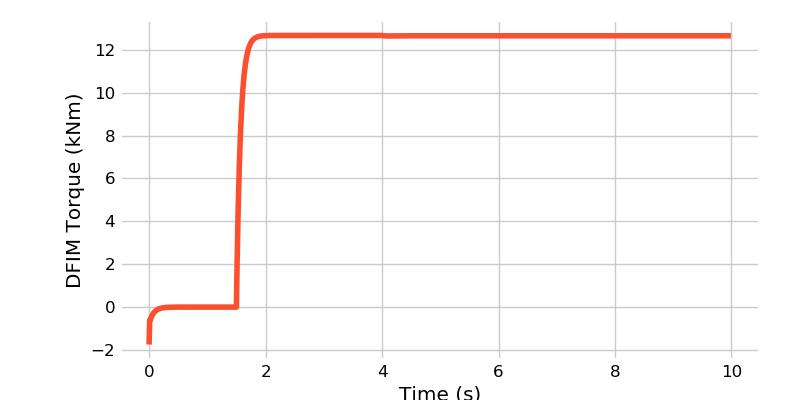

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharex = True)
fig.set_tight_layout(False)
axes.plot(T,Tau_e/1e3)
axes.set_xlabel('Time (s)')
axes.set_ylabel('DFIM Torque (kNm)')
fig.savefig('dfim_tau_e.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


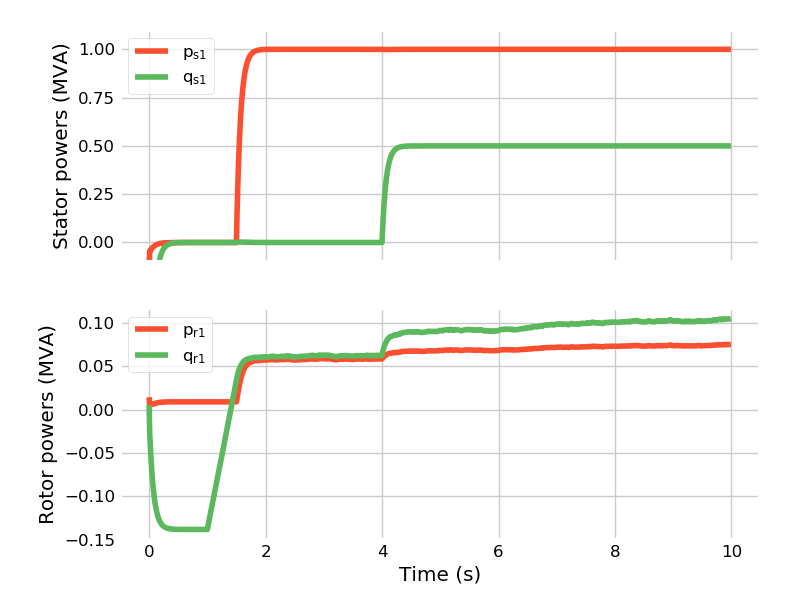

In [20]:
from matplotlib import rcParams
plt.style.use('presentation.mplstyle')
#rcParams.update({'figure.tight_layout':False})

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex = True)
fig.set_tight_layout(False)
axes[0].plot(T,P_s_1/1e6, label='$\sf p_{s1}$')
axes[0].plot(T,Q_s_1/1e6, label='$\sf q_{s1}$')
#axes[0].plot(T,P_s_2/1e6, label='$\sf p_{s2}$')
#axes[0].plot(T,Q_s_2/1e6, label='$\sf q_{s2}$')

axes[1].plot(T,P_r_1/1e6, label='$\sf p_{r1}$')
axes[1].plot(T,Q_r_1/1e6, label='$\sf q_{r1}$')
#axes[1].plot(T,P_r_2/1e6, label='$\sf p_{r2}$')
#axes[1].plot(T,Q_r_2/1e6, label='$\sf q_{r2}$')

axes[0].legend(loc='best')
axes[1].legend(loc='best')

        
axes[0].set_ylabel('Stator powers (MVA)')
axes[1].set_ylabel('Rotor powers (MVA)')
axes[1].set_xlabel('Time (s)')
axes[0].set_ylim([-0.1,1.1])
#axes[0].set_xlim([0,3.0])


fig.savefig('dfim_pq_s_pq_r.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>


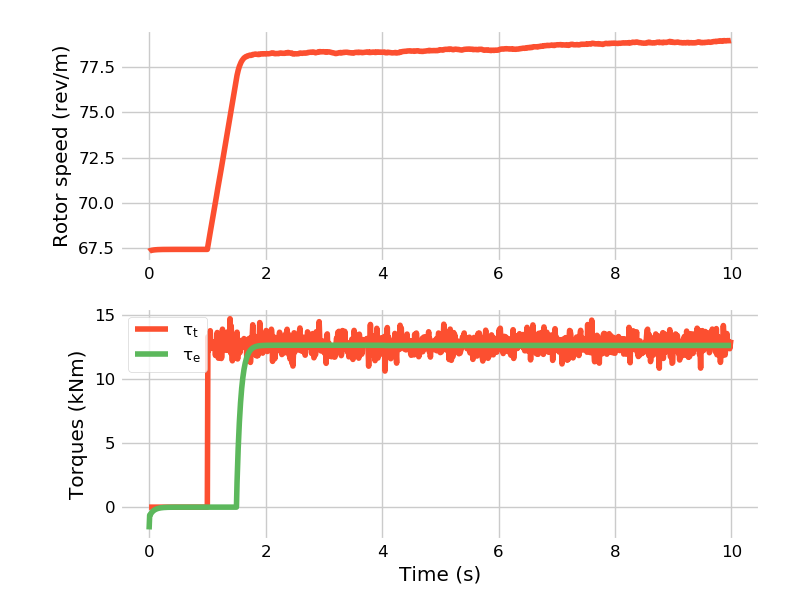

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig.set_tight_layout(False)

axes[0].plot(T,Omega_t*60/(2*np.pi))

axes[1].plot(T,Tau_t/20.0/1000, label='$\sf \\tau_t$')
axes[1].plot(T,Tau_e/1000, label='$\sf \\tau_e$')
#axes[1].plot(T,P_r_2/1e6, label='$\sf p_{r2}$')
#axes[1].plot(T,Q_r_2/1e6, label='$\sf q_{r2}$')

axes[1].legend(loc='best')

        
axes[0].set_ylabel('Rotor speed (rev/m)')
axes[1].set_ylabel('Torques (kNm)')
axes[1].set_xlabel('Time (s)')
#axes[0].set_ylim([0,2.5])
#axes[0].set_xlim([0,3.0])

fig.savefig('dfim_omega_taus.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>


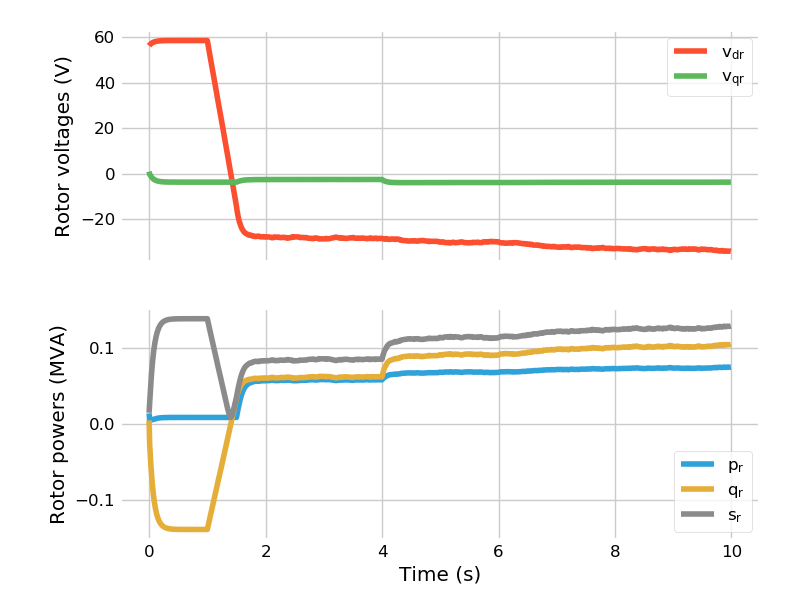

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex = True)
fig.set_tight_layout(False)
axes[0].plot(T,V_dr, label='$\sf v_{dr}$')
axes[0].plot(T,V_qr, label='$\sf v_{qr}$')


axes[1].plot(T,P_r_1/1e6, label='$\sf p_{r}$', color = colors[2])
axes[1].plot(T,Q_r_1/1e6, label='$\sf q_{r}$', color = colors[3])
axes[1].plot(T,(P_r_1**2+Q_r_1**2)**0.5/1e6, label='$\sf s_{r}$', color = colors[4])

axes[0].legend(loc='best')
axes[1].legend(loc='best')

        
axes[0].set_ylabel('Rotor voltages (V)')
axes[1].set_ylabel('Rotor powers (MVA)')
axes[1].set_xlabel('Time (s)')
#axes[0].set_ylim([0,2.5])
#axes[0].set_xlim([0,3.0])


fig.savefig('dfim_rotor_v_powers.svg', bbox_inches='tight')




<IPython.core.display.Javascript object>


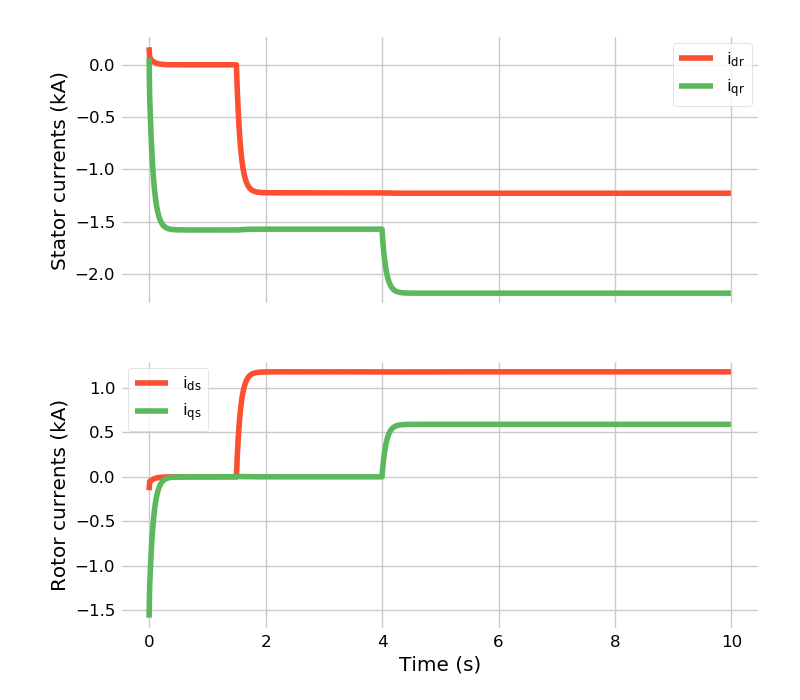

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 7), sharex = True)
fig.set_tight_layout(False)

axes[0].plot(T,I_dr/1000, label='$\sf i_{dr}$')
axes[0].plot(T,I_qr/1000, label='$\sf i_{qr}$')
axes[1].plot(T,I_ds/1000, label='$\sf i_{ds}$')
axes[1].plot(T,I_qs/1000, label='$\sf i_{qs}$')

axes[0].legend()
axes[1].legend()

        
axes[0].set_ylabel('Stator currents (kA)')
axes[1].set_ylabel('Rotor currents (kA)')
axes[1].set_xlabel('Time (s)')
#axes[0].set_ylim([0,2.5])
#axes[0].set_xlim([0,3.0])


fig.savefig('dfim_i_s_i_r.svg', bbox_inches='tight')
